# Modelling 5G Network Cascade in the United States

For these simulations, I used Networkx, a python library with built in graph generators. I built a number of functions to 
* Create a graph
* Print a graph
* Seed a starting early adopter
* Evaluate whether a node in the graph should adopt 5G
* Iterate through the graph in a cascade
* Calculate the density of a cluster within the graph

I created all of this code myself with the exception of the getClusters definition, which I drew from existing code on how to find clusters in a graph.

*Note: There is randomness in the seeding of the graphs and start nodes. As such, the output here may not match the results in the report.*

## Basic Functions

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import re
from sklearn.cluster import AffinityPropagation
import numpy as np

In [2]:
# set cluster numbers
# drawn from this stackoverflow answer https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python

def getClusters(graph):
    nn = len(G.nodes)
    mat = np.empty((nn, nn), dtype=float)
    mat.fill(-100.0)
    np.fill_diagonal(mat, -0.0)

    preds = nx.jaccard_coefficient(G, G.edges)
    for u, v, j in preds:
        mat[u,v] = -100 * (1 - j)
    from sklearn.cluster import AffinityPropagation
    np.median(mat)
    af = AffinityPropagation(affinity="euclidean", random_state = 0)
    lab = af.fit_predict(mat)
    return lab

In [3]:
# set an attribute for each node for adopting 5G, initialize to zero

def initializeAttributes(graph):
    clusters = getClusters(graph)
    cascade = {}
    for node in list(G):
        cascade[node] = {"adopt5G": 0, "start":0, "checked":0, "p":0, "access5G":1, "cluster": clusters[node]}
    nx.set_node_attributes(G, cascade)
    for node in list(G):
        cluster = clusters[node]
        if cluster % 4 == 0:
            cascade[node] = {"access5G": 0}
    nx.set_node_attributes(G, cascade)

In [4]:
# select random starting node and update attribute

def setStartNode(graph):
    eligibleNodes = [x for x,y in G.nodes(data=True) if y['access5G']==1]
    start = random.choice(eligibleNodes)
    #start = random.randint(0, len(list(graph))-1)
    nx.set_node_attributes(graph, {start: {"adopt5G":1, "start":1, "checked":1}})
    return start

In [5]:
# determine proportion of neighbors who adopted 5G
# d = number of neighbors
# p = proportion of neighbors who's adopted a

def neighborAdopters(graph,node_number):
    neighbors = list(nx.neighbors(graph, node_number))
    d = len(neighbors)
    G_small = graph.subgraph(neighbors)
    adoption = len([x for x,y in G_small.nodes(data=True) if y['adopt5G']==1])
    p = adoption / d
    nx.set_node_attributes(graph, {node_number: {"p":p}})
    nx.set_node_attributes(graph, {node_number: {"neighbors":neighbors}})

In [6]:
# set adoption threshold
# a = payoff of both adopting a (5G)
# b = payoff of both adopting b (4G)

def updateThreshold(graph, node_number,a,b):
    nx.set_node_attributes(graph, {node_number: {"checked":1}})
    p = nx.get_node_attributes(G,'p')[node_number]
    eligible = nx.get_node_attributes(G,'access5G')[node_number]
    print('p', p)
    print('b/a+b',(b/(a+b)))
    print('access to 5g?', nx.get_node_attributes(G,'access5G')[node_number]==1)
    print('adopt 5g?', (p >= b/(a+b)) and eligible==1)

    if (p >= b/(a+b)) and eligible==1:
        nx.set_node_attributes(graph, {node_number: {"adopt5G":1}})

In [7]:
# print graph color coded to show adoption of 5G
# blue = starting node
# red = adopt 5G
# green = access to 5G

def printGraph(graph):
    start = [x for x,y in graph.nodes(data=True) if y['adopt5G']==1 and y['start']==1]
    eligibles = [x for x,y in graph.nodes(data=True) if y['access5G']==1 and y['start']==0 and y['adopt5G']==0]
    adopters = [x for x,y in graph.nodes(data=True) if y['adopt5G']==1 and y['start']==0]
    nonadopters = [x for x,y in graph.nodes(data=True) if y['adopt5G']==0 and y['access5G']==0]

    labels = {}
    for n in G:
        if n in eligibles:
            labels[n] = 'eligible'
        if n in adopters:
            labels[n] = '5G'
    pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes
    options = {"edgecolors": "tab:gray", "node_size": 800}


    options = {"edgecolors": "tab:gray", "node_size": 800, }
    nx.draw_networkx_nodes(G, pos, nodelist=start, node_color="tab:blue", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=adopters, node_color="tab:red", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=nonadopters, node_color="tab:grey", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=eligibles, node_color="tab:green", **options)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    labels = {}
    for n in G:
        labels[n] = n
    nx.draw_networkx_labels(G, pos, labels,font_size=12, font_color="whitesmoke")

    ax = plt.gca()
    ax.margins(0.25)
    plt.axis("off")
    plt.show()

In [8]:
# determine whether node will adopt

def algorithm(graph, node):
    print('node: ', node)
    
    # check threshold
    updateThreshold(graph,node, a,b)
    next_neighbors = nx.get_node_attributes(graph,'neighbors')[node]
    # return next up
    check_next = graph.subgraph(next_neighbors)
    printGraph(graph)
    if nx.get_node_attributes(graph,'adopt5G')[node]==1:
        return check_next
    else:
        return []

In [9]:
# calculate the proportion of adopters across the graph

def cascade_rate(graph):
    print('access', len([x for x,y in graph.nodes(data=True) if y['access5G']==1]))
    print('adopters' ,len([x for x,y in graph.nodes(data=True) if y['adopt5G']==1]) )
    print('% adopters', len([x for x,y in graph.nodes(data=True) if y['adopt5G']==1])/len([x for x,y in graph.nodes(data=True) if y['access5G']==1]))
    print('full cascade', len([x for x,y in graph.nodes(data=True) if y['adopt5G']==1])==len([x for x,y in graph.nodes(data=True) if y['access5G']==1]))
    return len([x for x,y in graph.nodes(data=True) if y['adopt5G']==1])/len([x for x,y in graph.nodes(data=True) if y['access5G']==1])

## Run Simulations

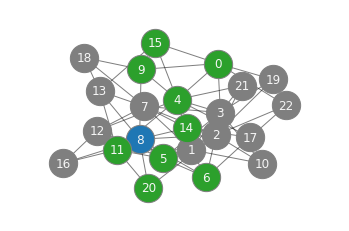

In [10]:
#Set up basic graph
G = nx.barabasi_albert_graph(23, 3, seed=11)
initializeAttributes(G)
start = setStartNode(G)
printGraph(G)

# Reset Graph, Same Start Node
# cascade = {}
# for node in list(G):
#     cascade[node] = {"adopt5G": 0, "checked":0}
# nx.set_node_attributes(G, cascade)
# nx.set_node_attributes(G, {start: {"adopt5G":1, "start":1, "checked":1}})
# printGraph(G)

In [11]:
# SET PAYOFFS HERE
a = 2
b = 1

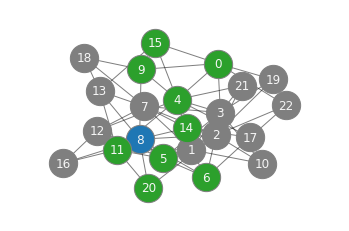

node:  5
p 0.14285714285714285
b/a+b 0.3333333333333333
access to 5g? True
adopt 5g? False


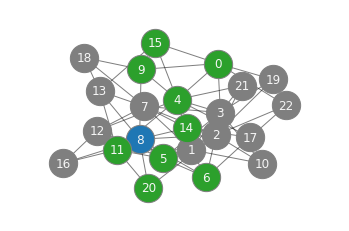

node:  6
p 0.2
b/a+b 0.3333333333333333
access to 5g? True
adopt 5g? False


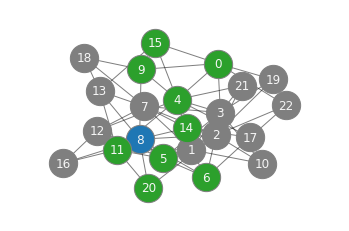

node:  9
p 0.25
b/a+b 0.3333333333333333
access to 5g? True
adopt 5g? False


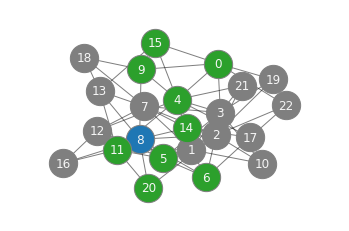

node:  14
p 0.25
b/a+b 0.3333333333333333
access to 5g? True
adopt 5g? False


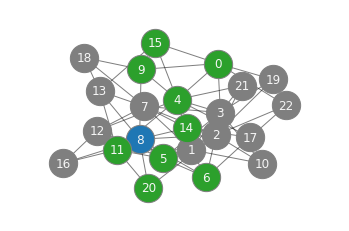

node:  20
p 0.3333333333333333
b/a+b 0.3333333333333333
access to 5g? True
adopt 5g? True


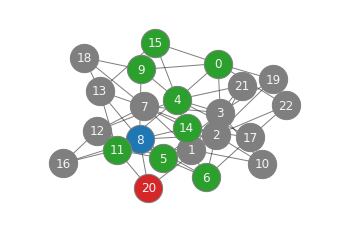

next [11]
node:  11
p 0.16666666666666666
b/a+b 0.3333333333333333
access to 5g? True
adopt 5g? False


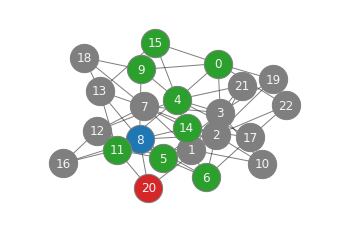

next []


In [12]:
# Chart network diffusion via an early adopter starter node

startNeighbors = list(nx.neighbors(G, start))
G_startNeighbors = G.subgraph(startNeighbors)
printGraph(G)

next = [x for x,y in G_startNeighbors.nodes(data=True) if y['adopt5G']==0 and y['access5G']==1]
while next!= []:
    final = []
    for x in set(next):
        neighborAdopters(G,x)
    for x in set(next):
        next1= algorithm(G,x)
        final.extend(next1)
    next_iteration = G.subgraph(final)
    next = [x for x,y in next_iteration.nodes(data=True) if y['adopt5G']==0 and y['access5G']==1]
    print('next', next)

In [13]:
cascade_rate(G)

access 10
adopters 2
% adopters 0.2
full cascade False


0.2

## Clustering as a Blocker to Cascades

In [14]:
# get density, per Kleinberg and Easley's definiton, p574
# density = minimum fraction of neighbors within the cluster
# iterate through all nodes in a given cluster, find minimum density, set for all nodes in the cluster

def calculateDensity(graph):
    cascade = {}
    for node in G:
        cluster = nx.get_node_attributes(G,'cluster')[node]
        neighbors = nx.subgraph(G, list(nx.neighbors(G, node)))
        density = len([x for x,y in neighbors.nodes(data=True) if y['cluster']== cluster]) / len([x for x,y in neighbors.nodes(data=True)])
        cascade[node] = {"density": density}

    nx.set_node_attributes(G, cascade)

    clusters = set(list(nx.get_node_attributes(G,'cluster').values()))

    for cluster in clusters:
        all_cluster = nx.subgraph(G,([x for x,y in G.nodes(data=True) if y['cluster']== cluster]))
        densities = nx.get_node_attributes(all_cluster,'density')
        cluster_density = min(densities.values())
        for node in all_cluster:
            nx.set_node_attributes(graph, {node: {"density": cluster_density}})
    print(set(list(nx.get_node_attributes(G,'density').values())))

In [15]:
# set adoption threshold
# a = payoff of both adopting a (5G)
# b = payoff of both adopting b (4G)

def updateThreshold(graph, node_number,a,b):
    nx.set_node_attributes(graph, {node_number: {"checked":1}})
    p = nx.get_node_attributes(G,'p')[node_number]
    density = nx.get_node_attributes(G,'density')[node_number]
    eligible = nx.get_node_attributes(G,'access5G')[node_number]
    print('p', p)
    print('b/a+b',(b/(a+b)))
    print('')
    print('1-q',(1-(b/(a+b))))
    print('cluster_density', density)
    print('density > 1-q?', density > (1-(b/(a+b))))
    print('adopt 5g?', (p >= b/(a+b)) and eligible==1)
    

    if (p >= b/(a+b)) and eligible==1:
        nx.set_node_attributes(graph, {node_number: {"adopt5G":1}})

In [16]:
# create dense graph
G = nx.ring_of_cliques(3,6)
initializeAttributes(G)
for node in G:
    nx.set_node_attributes(G, {node: {"access5G":1}})
#printGraph(G)

In [17]:
calculateDensity(G)

{0.8333333333333334}


In [18]:
start = setStartNode(G)
#printGraph(G)

In [19]:
# SET PARAMETERS HERE
a = 4
b = 1

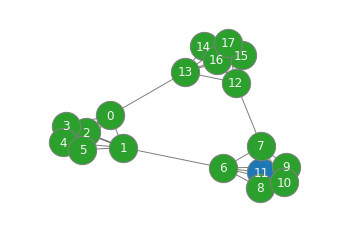

node:  6
p 0.16666666666666666
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? False


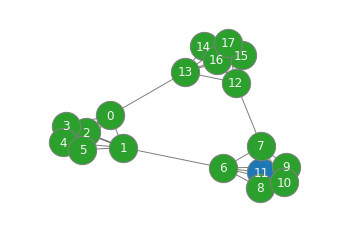

node:  7
p 0.16666666666666666
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? False


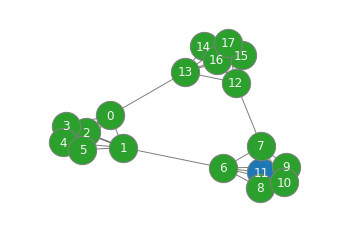

node:  8
p 0.2
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? True


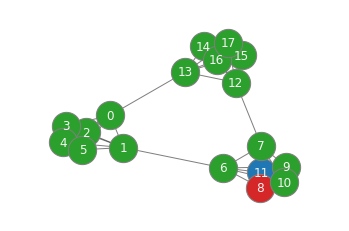

node:  9
p 0.2
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? True


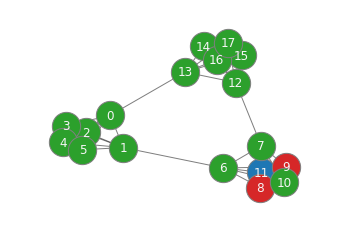

node:  10
p 0.2
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? True


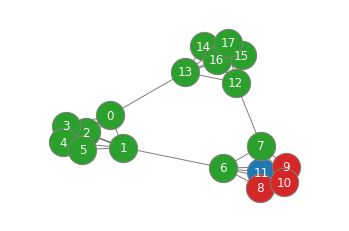

next [6, 7]
node:  6
p 0.6666666666666666
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? True


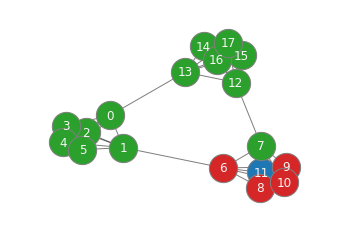

node:  7
p 0.6666666666666666
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? True


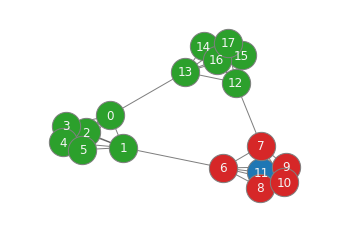

next [1, 12]
node:  1
p 0.16666666666666666
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? False


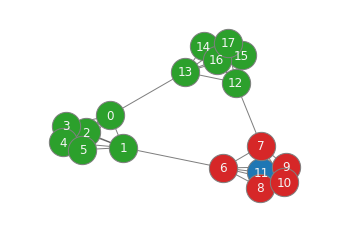

node:  12
p 0.16666666666666666
b/a+b 0.2

1-q 0.8
cluster_density 0.8333333333333334
density > 1-q? True
adopt 5g? False


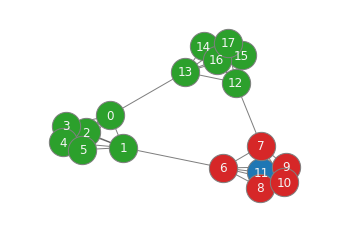

next []


In [20]:
# Chart network diffusion via an early adopter starter node

startNeighbors = list(nx.neighbors(G, start))
G_startNeighbors = G.subgraph(startNeighbors)
printGraph(G)

next = [x for x,y in G_startNeighbors.nodes(data=True) if y['adopt5G']==0 and y['access5G']==1]
while next!= []:
    final = []
    for x in set(next):
        neighborAdopters(G,x)
    for x in set(next):
        next1= algorithm(G,x)
        final.extend(next1)
    next_iteration = G.subgraph(final)
    next = [x for x,y in next_iteration.nodes(data=True) if y['adopt5G']==0 and y['access5G']==1]
    print('next', next)

## Run Larger Simulations

In [21]:
# For Larger Graphs (same functions, no print statements)

def updateThreshold(graph, node_number,a,b):
    nx.set_node_attributes(graph, {node_number: {"checked":1}})
    p = nx.get_node_attributes(G,'p')[node_number]
    eligible = nx.get_node_attributes(G,'access5G')[node_number]
    if (p >= b/(a+b)) and eligible==1:
        nx.set_node_attributes(graph, {node_number: {"adopt5G":1}})

def algorithm(graph, node):
    updateThreshold(graph,node, a,b)
    next_neighbors = nx.get_node_attributes(graph,'neighbors')[node]
    # return next up
    check_next = graph.subgraph(next_neighbors)

    if nx.get_node_attributes(graph,'adopt5G')[node]==1:
        return check_next
    else:
        return []

In [22]:
# Set up basic graph
G = nx.barabasi_albert_graph(230, 3, seed = 42)
initializeAttributes(G)
start = setStartNode(G)

# Reset Graph, Same Start Node
# cascade = {}
# for node in list(G):
#     cascade[node] = {"adopt5G": 0, "checked":0}
# nx.set_node_attributes(G, cascade)
# nx.set_node_attributes(G, {start: {"adopt5G":1, "start":1, "checked":1}})

In [23]:
# SET PAYOFFS HERE
a = 237
b = 1

In [24]:
# run simulations

startNeighbors = list(nx.neighbors(G, start))
G_startNeighbors = G.subgraph(startNeighbors)

next = [x for x,y in G_startNeighbors.nodes(data=True) if y['checked']==0]
while next!= []:
    final = []
    for x in set(next):
        neighborAdopters(G,x)
    for x in set(next):
        next1= algorithm(G,x)
        final.extend(next1)
    next_iteration = G.subgraph(final)
    next = [x for x,y in next_iteration.nodes(data=True) if y['checked']==0]
cascade_rate(G)

access 171
adopters 171
% adopters 1.0
full cascade True


1.0